# Text Detection

https://mindee.github.io/doctr/

https://github.com/mindee/doctr/tree/main/references/detection

https://mindee.com/blog/vin-extraction-with-doctr/

https://mindee.github.io/doctr/using_doctr/using_models.html

https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173


In [67]:
%matplotlib inline
import os
os.environ['USE_TF'] = '1'
from importlib import reload 
import text_detection_utils as utils

reload(utils)

from doctr.io import DocumentFile
from doctr.models import ocr_predictor

from matplotlib.patches import Polygon
import xml.etree.ElementTree as ET
import numpy as np
import random
import hashlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

predictor = ocr_predictor(pretrained=True)

In [68]:
import pickle
import pandas as pd
import json 

df = pd.read_pickle('../../pickle/df.pickle')
df.head()

index         word_id  gray_level     x    y    w   h  tag transcription  \
0      0  a01-000u-00-00         154   408  768   27  51   AT             A   
1      1  a01-000u-00-01         154   507  766  213  48   NN          MOVE   
2      2  a01-000u-00-02         154   796  764   70  50   TO            to   
3      3  a01-000u-00-03         154   919  757  166  78   VB          stop   
4      4  a01-000u-00-04         154  1185  754  126  61  NPT           Mr.   

                                   word_img_path  ...   form_id  writer_id  \
0  ../data/words/a01/a01-000u/a01-000u-00-00.png  ...  a01-000u        000   
1  ../data/words/a01/a01-000u/a01-000u-00-01.png  ...  a01-000u        000   
2  ../data/words/a01/a01-000u/a01-000u-00-02.png  ...  a01-000u        000   
3  ../data/words/a01/a01-000u/a01-000u-00-03.png  ...  a01-000u        000   
4  ../data/words/a01/a01-000u/a01-000u-00-04.png  ...  a01-000u        000   

   text_id number_of_sentences word_seg total_lines correct_lines total_words  \
0      a01                   2      prt           7             5          52   
1      a01                   2      prt           7             5          52   
2      a01                   2      prt           7             5          52   
3      a01                   2      prt           7             5          52   
4      a01                   2      prt           7             5          52   

   correct_words                form_img_path_y  
0             36  ../data/formsA-D/a01-000u.png  
1             36  ../data/formsA-D/a01-000u.png  
2             36  ../data/formsA-D/a01-000u.png  
3             36  ../data/formsA-D/a01-000u.png  
4             36  ../data/formsA-D/a01-000u.png  

[5 rows x 23 columns]

In [69]:
print(len(df))

96420


In [70]:
clean_df=df[df['total_words'] == df['correct_words']]
bad_df = df[df['total_words'] != df['correct_words']]
print("Il y a", len(clean_df), "mots bien récupérés")
print("Il y a", len(bad_df), "mots pas bien récupérés")
print('\n')
print("Il y a", len(set(df['form_id'].values)), "forms dans le dataset complet")
print("Il y a", len(set(clean_df['form_id'].values)), "forms dans le dataset utilisé")

Il y a 41981 mots bien récupérés
Il y a 54439 mots pas bien récupérés


Il y a 1539 forms dans le dataset complet
Il y a 583 forms dans le dataset utilisé


In [71]:
clean_df.head()

index         word_id  gray_level     x    y    w    h  tag transcription  \
36     52  a01-000x-00-00         182   375  767   35   67   AT             A   
37     53  a01-000x-00-01         182   506  763  143   66   NN          MOVE   
38     54  a01-000x-00-02         182   730  760   44   70   TO            to   
39     55  a01-000x-00-03         182   832  764   89  114   VB          stop   
40     56  a01-000x-00-04         182  1001  760   84   71  NPT           Mr.   

                                    word_img_path  ...   form_id  writer_id  \
36  ../data/words/a01/a01-000x/a01-000x-00-00.png  ...  a01-000x        001   
37  ../data/words/a01/a01-000x/a01-000x-00-01.png  ...  a01-000x        001   
38  ../data/words/a01/a01-000x/a01-000x-00-02.png  ...  a01-000x        001   
39  ../data/words/a01/a01-000x/a01-000x-00-03.png  ...  a01-000x        001   
40  ../data/words/a01/a01-000x/a01-000x-00-04.png  ...  a01-000x        001   

    text_id number_of_sentences word_seg total_lines correct_lines  \
36      a01                   2      all           6             6   
37      a01                   2      all           6             6   
38      a01                   2      all           6             6   
39      a01                   2      all           6             6   
40      a01                   2      all           6             6   

   total_words  correct_words                form_img_path_y  
36          52             52  ../data/formsA-D/a01-000x.png  
37          52             52  ../data/formsA-D/a01-000x.png  
38          52             52  ../data/formsA-D/a01-000x.png  
39          52             52  ../data/formsA-D/a01-000x.png  
40          52             52  ../data/formsA-D/a01-000x.png  

[5 rows x 23 columns]

In [72]:
import random
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

rs = RandomState(MT19937(SeedSequence(42)))

random.seed(42)


## Building structure

### Finding full image coords

In [11]:
# doctr_coords_json = utils.find_full_img_coords(clean_df)

In [73]:
with open("doctr_coords.json") as f:
    doctr_coords_json = json.load(f)

# train_img_dict, val_img_dict = utils.split_in_train_val_img_dicts(clean_df, doctr_coords_json)

# Checking polygons' positions

In [74]:
with open("text_detection_train/labels.json") as f:
    train_json = json.load(f)
    
print(len(train_json), "images will be used for training")

with open("text_detection_val/labels.json") as f:
    val_json = json.load(f)
    
print(len(val_json), "images will be used for validation")

468 images will be used for training
116 images will be used for validation


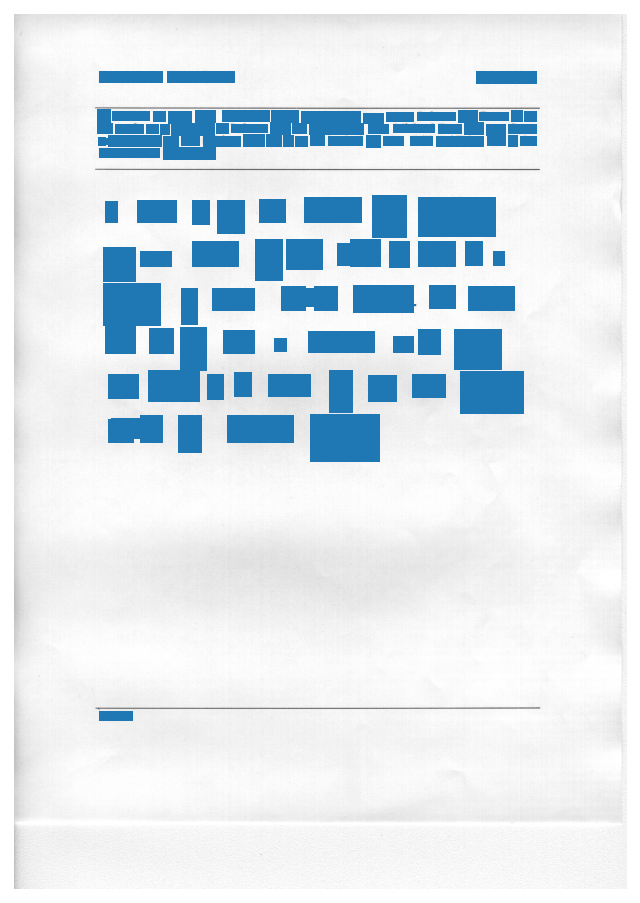

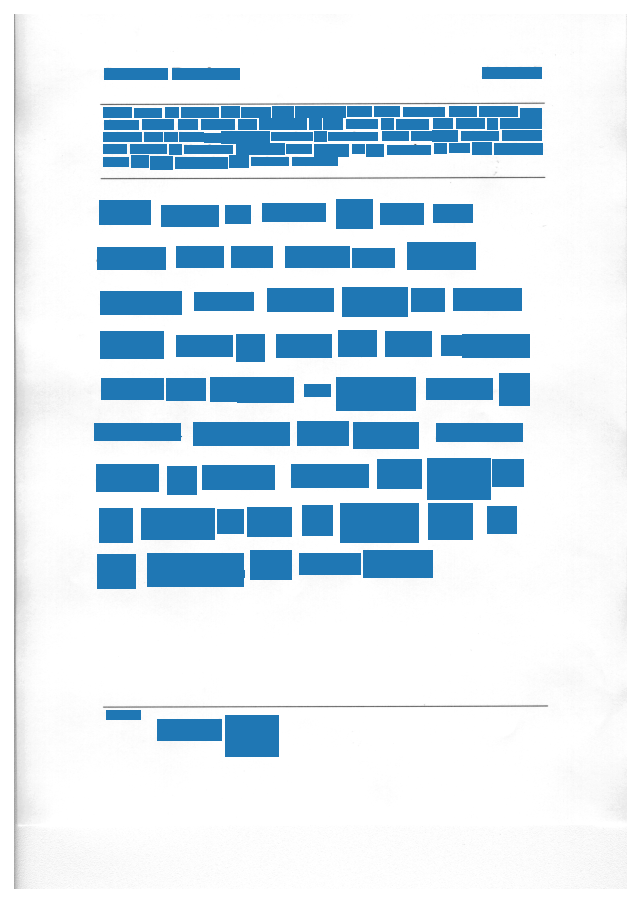

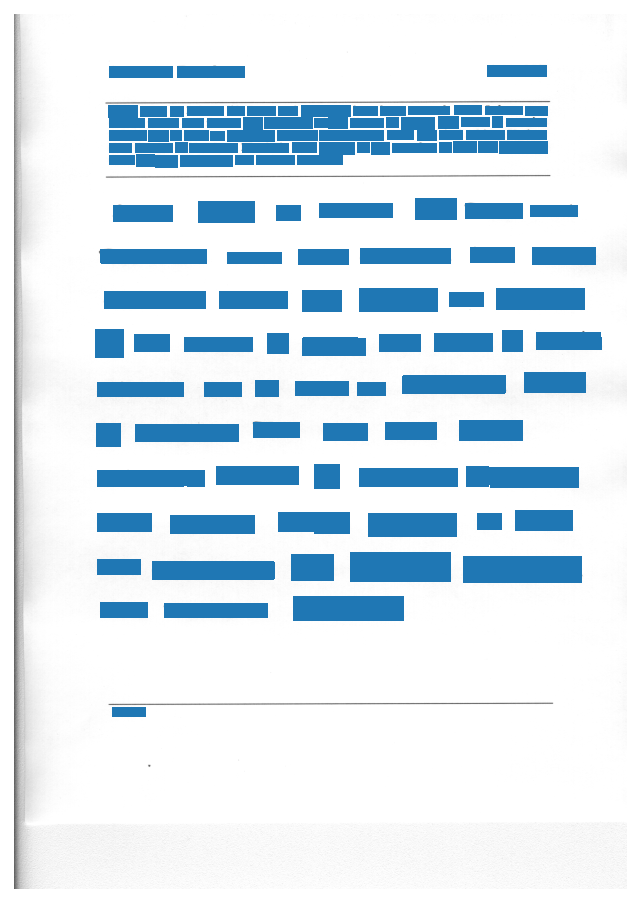

In [75]:
i = 0
stop = 2
for key in train_json:
    i += 1
    utils.plot_img_with_polygons(key, train_json[key])
    if i > stop:
        break

# Changing model's weights

In [ ]:
# python doctr/references/detection/train_tensorflow.py text_detection_train text_detection_val  db_resnet50 --pretrained  

# Testing

## Test without pretraining

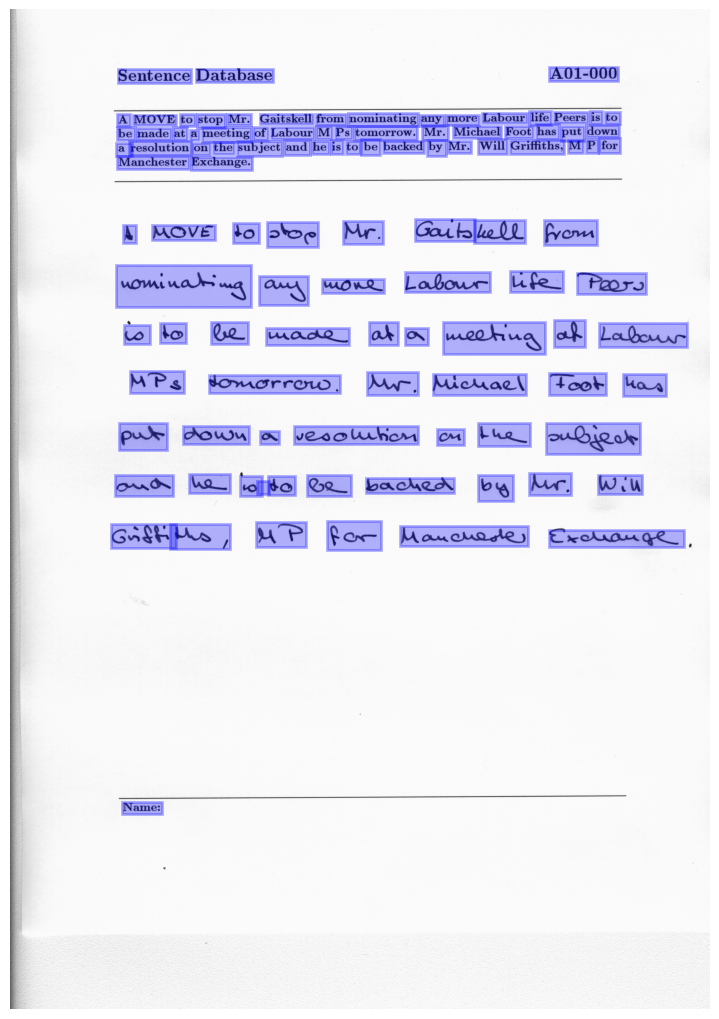

In [78]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

model = ocr_predictor(
    det_arch = 'db_resnet50',    
    reco_arch = 'crnn_vgg16_bn', 
    pretrained = True
)

utils.show_boxes(model, "../../data/formsA-D/a01-000u.png", False)


## Test with pretraining

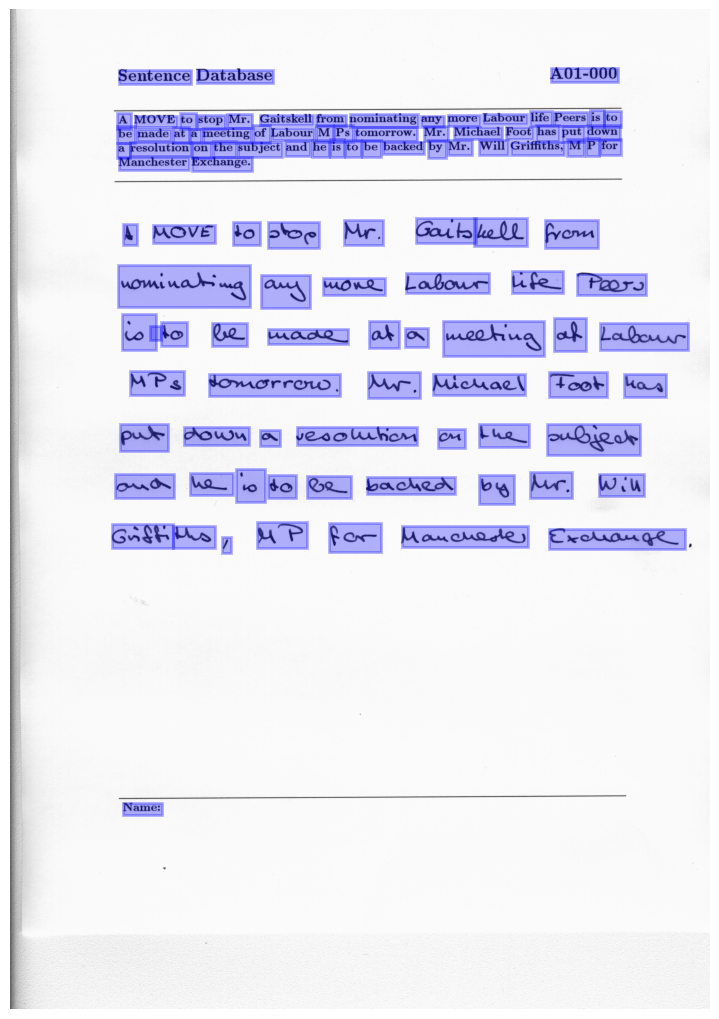

In [16]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# DET_CKPT = "db_resnet50_20221202-232725/weights"
DET_CKPT = "full_img/weights"

custom_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
custom_model.det_predictor.model.load_weights(DET_CKPT)


    
utils.show_boxes(custom_model, "../../data/formsA-D/a01-000u.png")

In [17]:
bad_form_ids = list(set(bad_df.form_id.values) - set(clean_df.form_id.values))
print(len(set(df.form_id.values)))
print(len(bad_form_ids))

1539
956


In [18]:
with open("text_detection_train/labels.json") as f:
    train_json = json.load(f)

with open("text_detection_val/labels.json") as f:
    val_json = json.load(f)

g06-045h


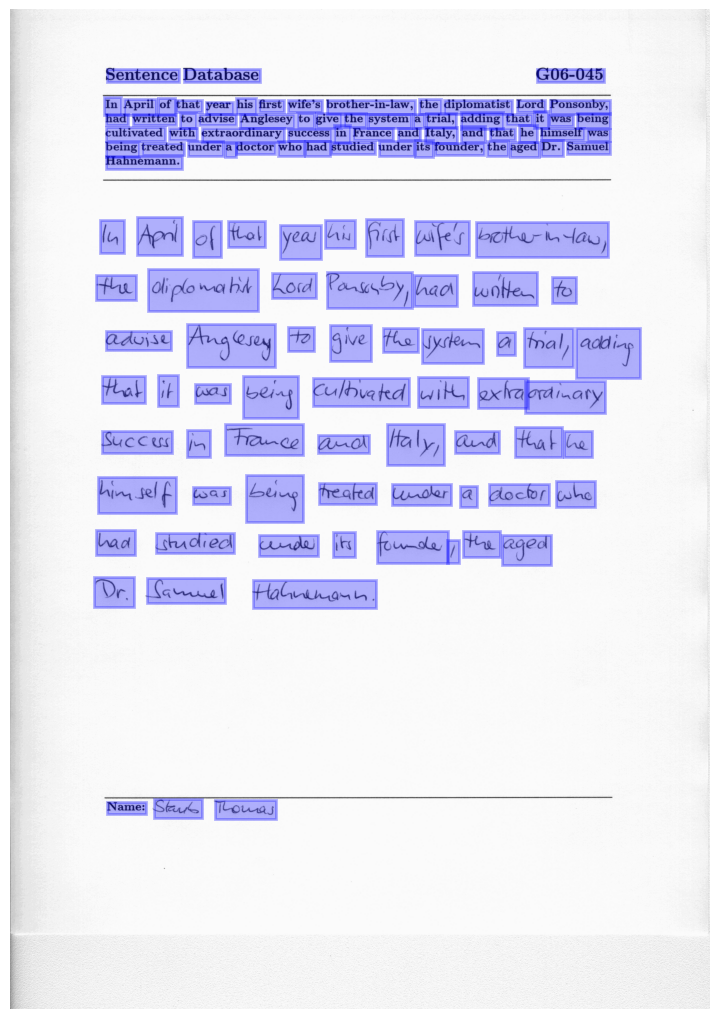

m04-138


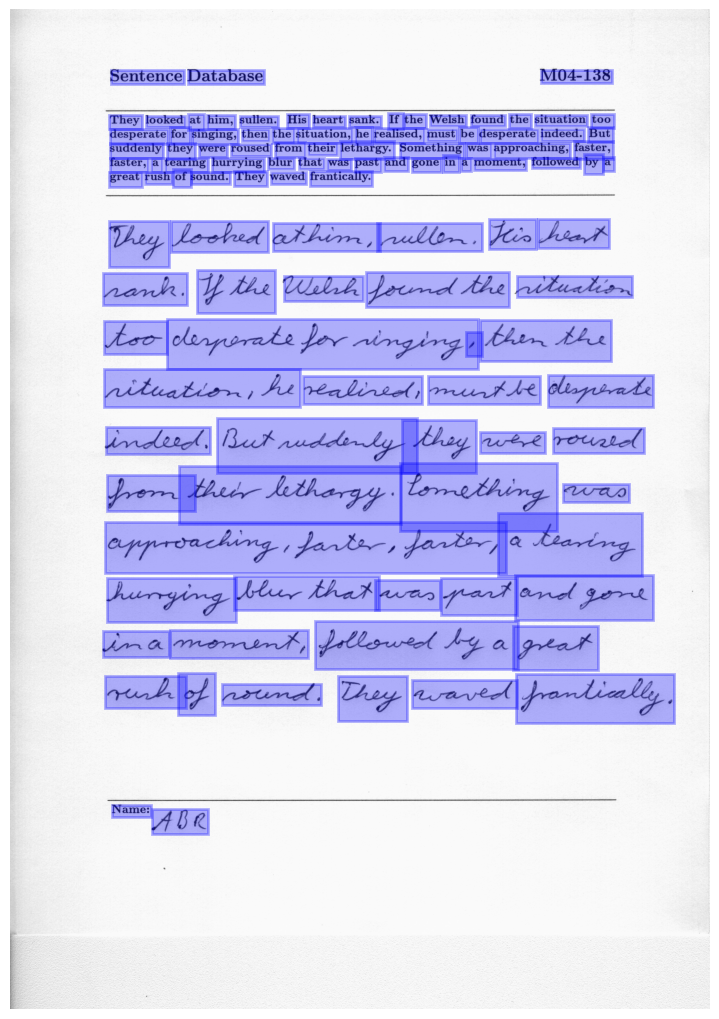

c03-021c


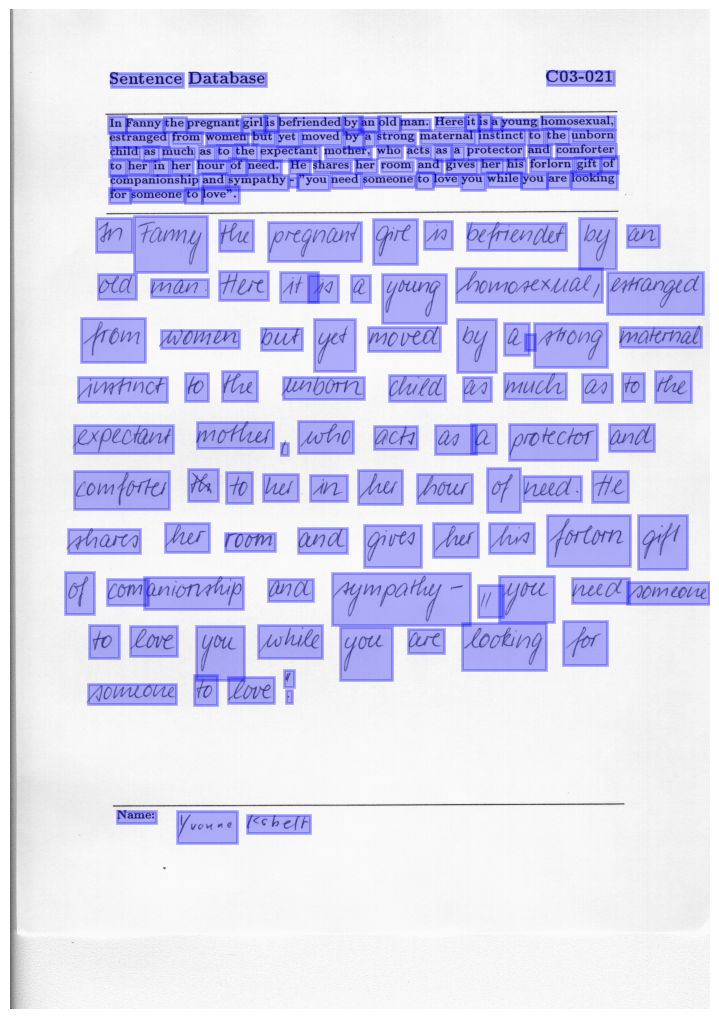

In [20]:
for i in range(3):
    print(bad_form_ids[i])
    utils.show_boxes(custom_model, "../../data/" + get_form_img_path_by_form_id(bad_form_ids[i]))

### Using full model

In [22]:
test_img_path = "../../data/" + get_form_img_path_by_form_id('e04-019')
doc = DocumentFile.from_images(test_img_path)
result = custom_model(doc)

In [ ]:
# print(sorted(
#     [[word.geometry[0][0], word.geometry[0][1], word.geometry[1][0], word.geometry[1][1]]
#     for page in result.pages for block in page.blocks for line in block.lines for word in line.words
# ], key=lambda x: x[0]
# ))

### Using detector only

In [24]:
det_res = custom_model.det_predictor(doc)

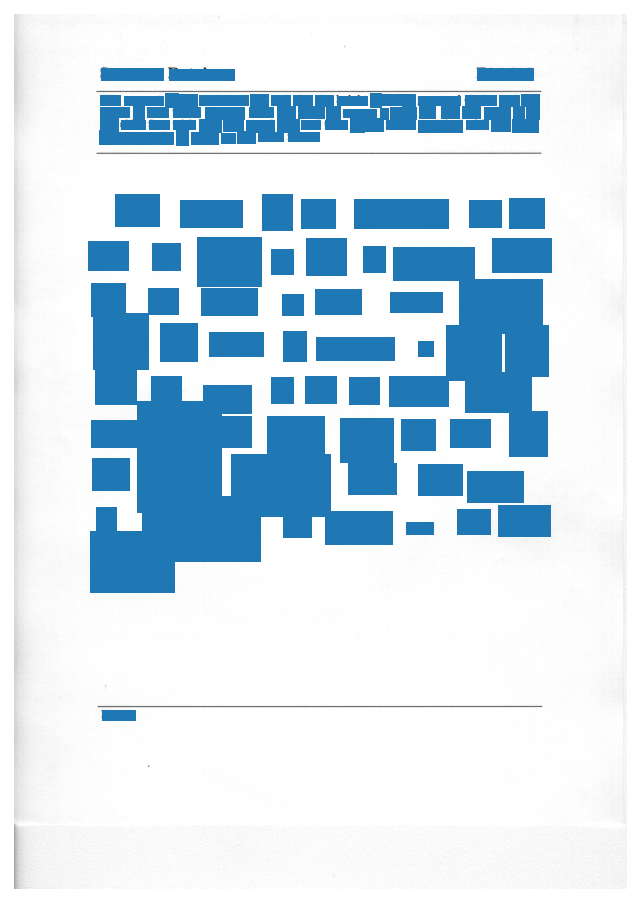

In [25]:
img_arr = plt.imread(test_img_path);

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.set_dpi(142)
plt.axis('off');

ax.imshow(img_arr, cmap='gray')


height = img_arr.shape[0]
width = img_arr.shape[1]
trans_coords = [[
    [arr[0] * width, arr[1] * height], #xmin #ymin
    [arr[2] * width, arr[1] * height], #xmax #ymin
    [arr[2] * width, arr[3] * height], #xmax #ymax
    [arr[0] * width, arr[3] * height], #xmin #ymax
] for arr in det_res[0]]

for trans_coord in trans_coords:
    polygon = Polygon(trans_coord)
    ax.add_patch(polygon)


# Evaluate

https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

## Checking on one specific image

In [80]:
import text_detection_utils


specific_img_row = clean_df.iloc[57]

### Using full model

In [40]:
form_id = specific_img_row.form_id
doc = DocumentFile.from_images(get_relative_img_path_from_form_id(form_id))
result = custom_model(doc)

In [41]:
box_coords = utils.get_all_found_box_coordinates(result, plt.imread(img_path))

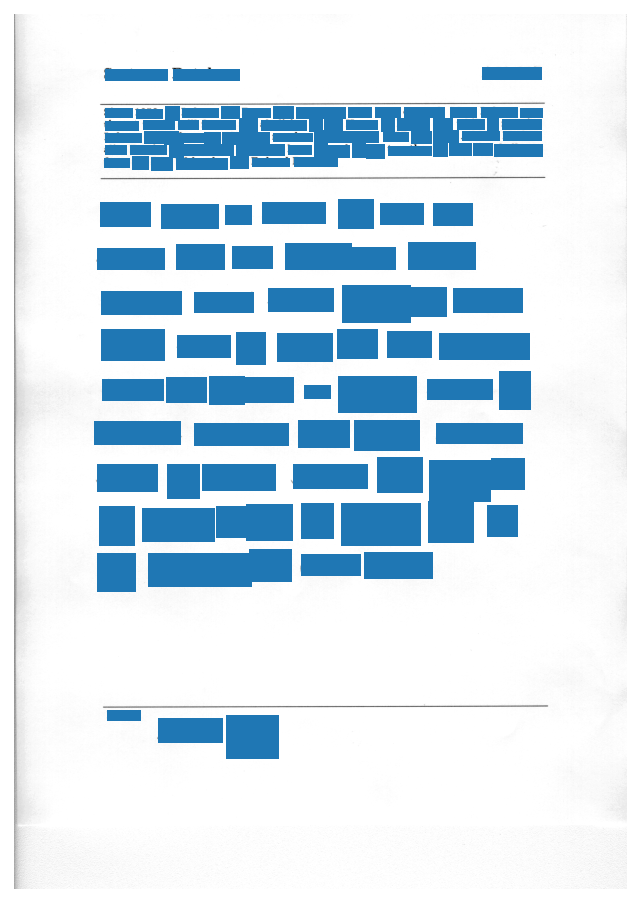

In [42]:
img_arr = plt.imread(img_path);

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.set_dpi(142)
plt.axis('off');

box_coords = utils.get_all_found_box_coordinates(result, img_arr)
for box_coord in box_coords:
    polygon = Polygon(box_coord)
    ax.add_patch(polygon)
                
ax.imshow(img_arr, cmap='gray');


### Using detector only

In [43]:
# img_path, form_id
img_path = utils.get_relative_img_path_from_form_id(form_id)

doc = DocumentFile.from_images(img_path)
# Return an array of boxes' coordinates with normalized values
res = custom_model.det_predictor(doc)

In [ ]:
# res[0] # xmin ymin xmax ymax confidence

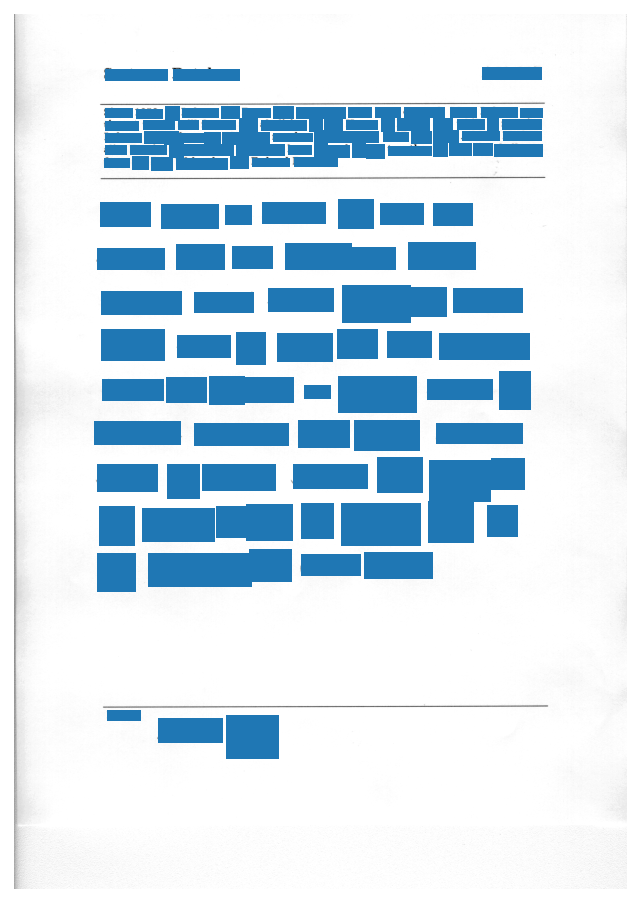

In [81]:
img_arr = plt.imread(img_path);

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.set_dpi(142)
plt.axis('off');

box_coords = utils.get_box_coordinates_from_flat_arr(res[0], img_arr)
for box_coord in box_coords:
    polygon = Polygon(box_coord)
    ax.add_patch(polygon)

# TODO add red squares with ground truth
# Ground truth exists only for handwritten letters so we need to take only the 
# coordinates starting from a certain y coordinate

# for box_coord in box_coords:
#     polygon = Polygon(box_coord)
#     ax.add_patch(polygon)
                
ax.imshow(img_arr, cmap='gray');

#### IoU

https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU
https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/

In [114]:
from shapely.geometry import box
from typing import List


ground_truth_polygons = utils.get_ground_truth_polygons_for_form(clean_df, form_id)

In [188]:
from importlib import reload 
import text_detection_utils as utils

reload(utils)

boundaries = utils.get_ground_truth_polygon_boundaries(ground_truth_polygons)

In [133]:
predicted_polygons = utils.get_predicted_polygons_for_form(custom_model, form_id, boundaries)

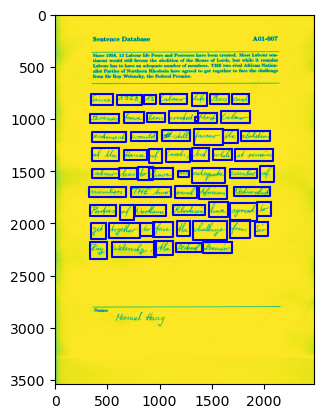

In [134]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

img_path = utils.get_relative_img_path_from_form_id(form_id)
img_arr = plt.imread(img_path)
plt.imshow(img_arr)
for blue in predicted_polygons:
    plt.plot(*blue.exterior.xy, color='b')

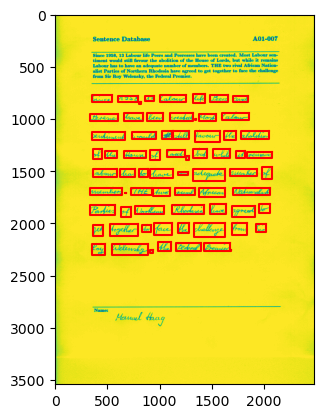

In [93]:
img_path = utils.get_relative_img_path_from_form_id(form_id)
img_arr = plt.imread(img_path)
plt.imshow(img_arr)
for red in ground_truth_polygons:
    plt.plot(*red.exterior.xy, color='r')
plt.show()

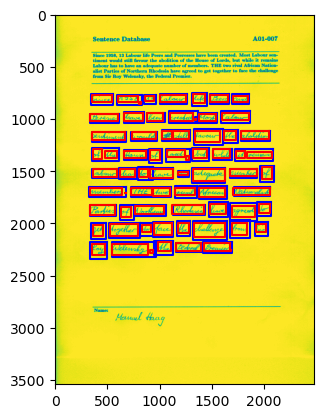

In [112]:
img_path = utils.get_relative_img_path_from_form_id(form_id)
img_arr = plt.imread(img_path)
plt.imshow(img_arr)
for blue in predicted_polygons:
    plt.plot(*blue.exterior.xy, color='b')
for red in ground_truth_polygons:
    plt.plot(*red.exterior.xy, color='r')

In [171]:
iou = utils.get_iou(ground_truth_polygons, predicted_polygons)
print('IOU: ', iou)

IOU:  0.6268188345462691
<class 'pandas.core.series.Series'>


In [165]:
reload(utils)

<module 'text_detection_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/text_detection/text_detection_utils.py'>

In [166]:
iou_list = [] 
form_ids = list(set(clean_df.form_id.values))
for form_id in form_ids:
    iou_list.append(utils.compute_iou(custom_model, clean_df, form_id))

In [181]:
res_df = pd.DataFrame({'form_id': form_ids, 'iou': iou_list})
res_df.head()

form_id       iou
0   a06-036  0.495999
1   b04-116  0.670507
2  g06-018p  0.620183
3  g06-050f  0.566892
4   a03-037  0.627130

In [182]:
res_df.describe()

iou
count  583.000000
mean     0.606221
std      0.052920
min      0.445608
25%      0.572470
50%      0.608302
75%      0.642458
max      0.731870

In [184]:
iou_threshold = 0.5
res_df['correct'] = res_df['iou'] > iou_threshold
res_df.head()

form_id       iou  correct
0   a06-036  0.495999    False
1   b04-116  0.670507     True
2  g06-018p  0.620183     True
3  g06-050f  0.566892     True
4   a03-037  0.627130     True

In [187]:
print("La IoU moyenne de notre modèle est de", res_df['iou'].mean())
print("Avec un threshold de", iou_threshold, ", il y a", len(res_df[res_df['correct'] == True]) / len(res_df),  '% de segmentation correct')

La IoU moyenne de notre modèle est de 0.6062213847245115
Avec un threshold de 0.5 , il y a 0.967409948542024 % de segmentation correct


In [198]:
bad_seg_form_id = res_df[res_df['iou'] == res_df['iou'].min()].iloc[0].form_id

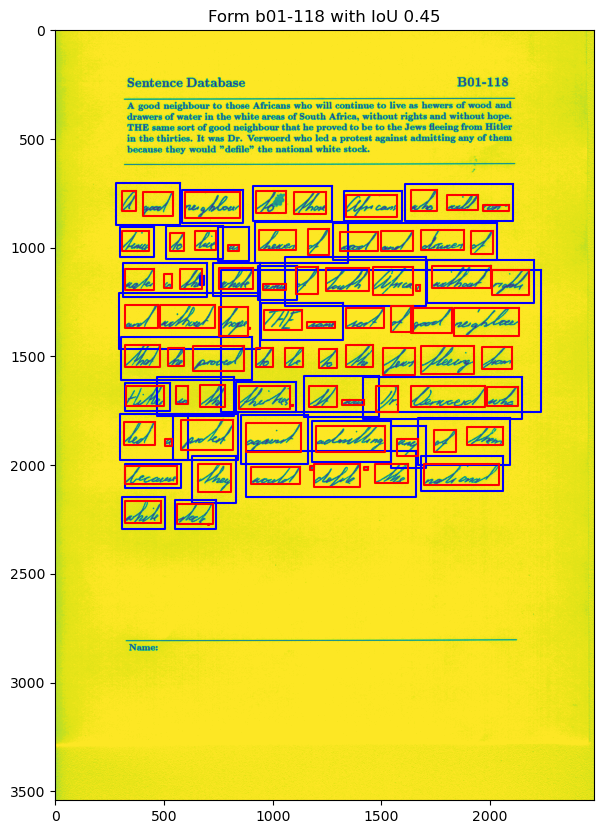

In [201]:
reload(utils)
utils.show_img_with_prediction_and_iou(custom_model, clean_df, bad_seg_form_id)

# Test with image outside dataset

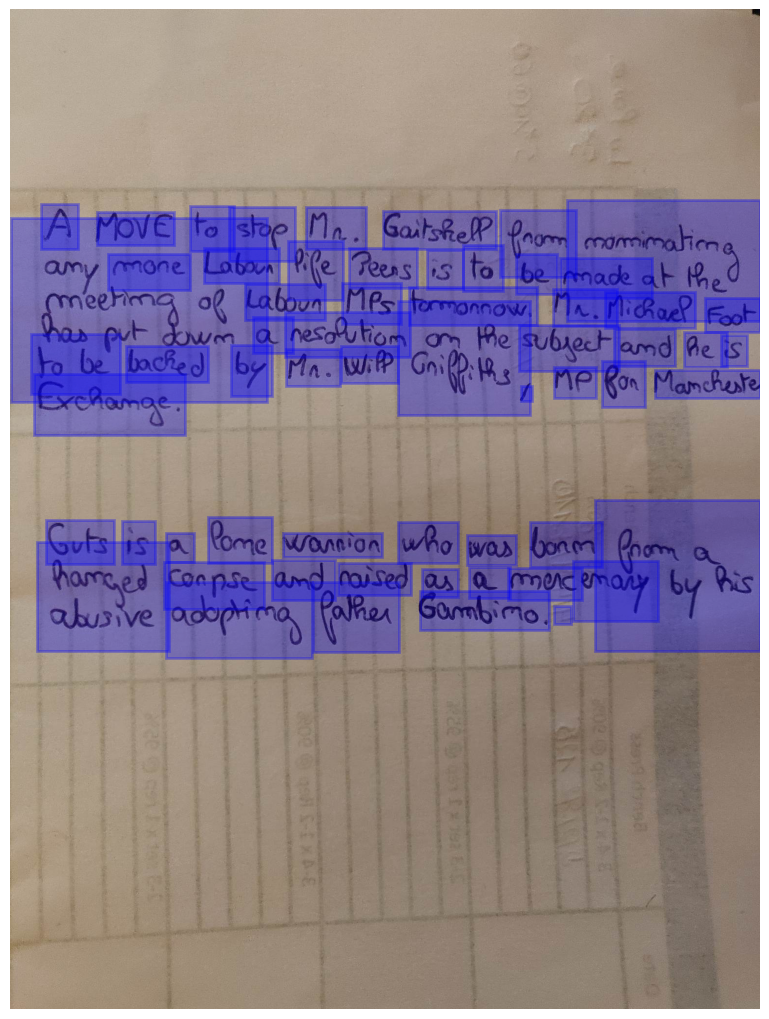

In [209]:
custom_doc = DocumentFile.from_images("custom_imgs/custom_writing.jpeg")
custom_res = custom_model(custom_doc)
custom_res.show(custom_doc)

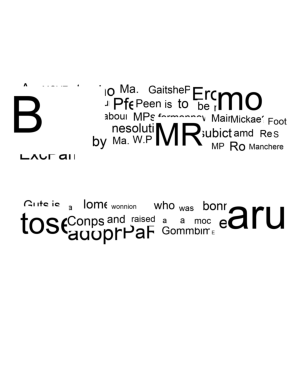

In [210]:
import matplotlib.pyplot as plt

synthetic_pages = custom_res.synthesize()
plt.imshow(synthetic_pages[0]); 
plt.axis('off');
plt.show()

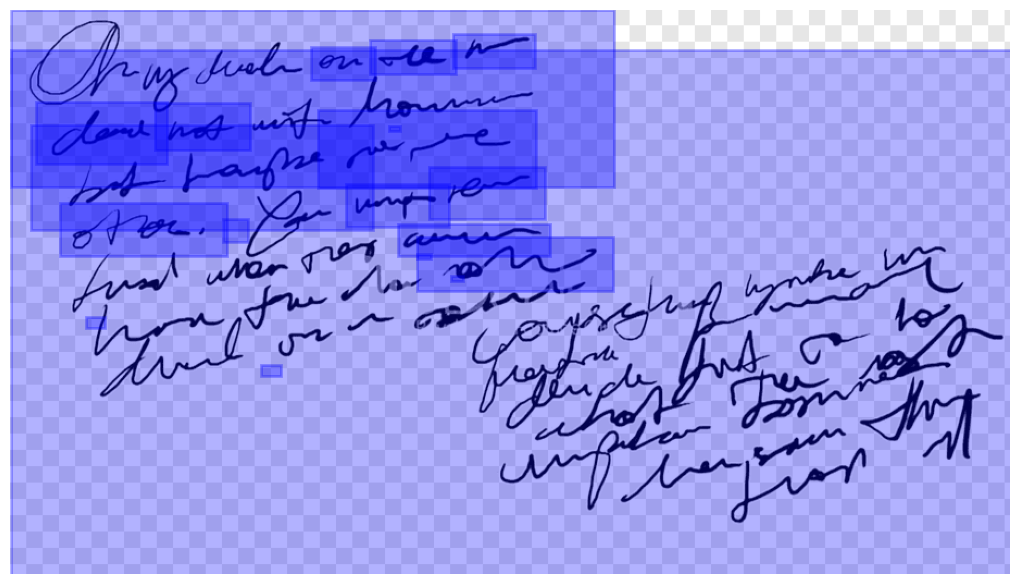

In [207]:
custom_doc = DocumentFile.from_images("custom_imgs/slightly_rotated_text.png")
custom_res = custom_model(custom_doc)
custom_res.show(custom_doc)